In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
import os.path
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns
import scipy.stats


# Directory for data
data_dir = "/Users/yshiga/Documents/Research/Carbon_Machine/Monthly/"

Using TensorFlow backend.


In [2]:
# This code is a sandbox to help with the development of a neural network using monthly variables 
# over north america trained on inverse flux estimates
# There are a series of plotting and processing soce snippets
# I also borrow from https://www.tensorflow.org/tutorials/keras/regression exmaples for plotting epoch vs 
# loss performance


In [3]:
# grid mapping function
def data2grid(lats,lons,data):
    # create grid of lat lon (expand lat by 5 degrees)
    xi = np.arange(lons.min(), lons.max()+1,1)
    yi = np.arange(lats.min(), lats.max()+5,1)
    xi, yi = np.meshgrid(xi, yi)
    zi = np.zeros(yi.shape) # place holder for flux variable

    # loop over values, find index of lat & lon, enter flux variable
    for i in range(len(data)):
        min_temp_lat=abs(lats[i]-yi[:,0])
        min_temp_lon=abs(lons[i]-xi[0,:])
        lat_ind = (min_temp_lat == min(min_temp_lat))
        lon_ind = (min_temp_lon == min(min_temp_lon))
        zi[lat_ind,lon_ind]=data[i]
    return xi, yi, zi

In [4]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [5]:
#def outlier_iqr(points,multiplier):
  #  q75, q25 = np.percentile(points, [75 ,25])
   # iqr = q75 - q25
    

(282204, 1)
(12, 9, 1)


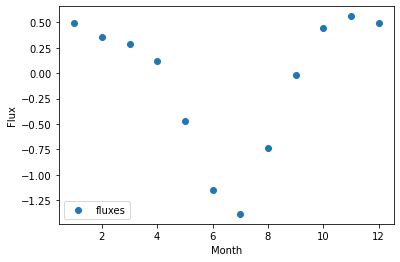

In [6]:
# Load in training fluxes, reshape, and transform scale

# filename for inverse carbon fluxes (units are umol/m2/s)
filename_flux = data_dir + "flux_training/geoinv-sif-monthly-2007-to-2015.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]

num_rows, num_cols = flux_var.shape # number of rows and columns

flux_var=flux_var.reshape((num_rows*num_cols, 1),) # reshape into one vector by stacking each column (month)

# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(flux_var, order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label="fluxes")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Flux')
plt.show()



In [7]:
#flux_out=mad_based_outlier(flux_var)
#sum(flux_out)

(282204, 1)
(282204, 1)
(282204, 1)
(282204, 1)
(12, 9, 1)


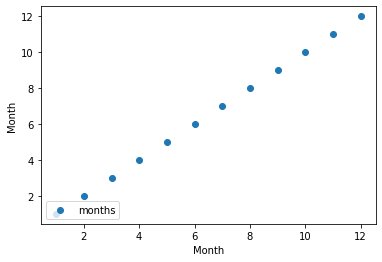

In [8]:
# load lat lon variables and create month variable
filename_narr = data_dir + "predictors/processed/narr-2007-NA-monthly.nc"
nc_narr = Dataset(filename_narr, 'r')  # open data file using netcdf reader
lat_var = np.array(nc_narr.variables["lat"]) # create numpy array note shape of lat vars is [space dimension ]
lon_var = np.array(nc_narr.variables["lon"]) # create numpy array note shape of lat vars is [space dimension ]

# tile to correct dimensions
lat_var_all=np.tile(lat_var,(1,12*9))
lon_var_all=np.tile(lon_var,(1,12*9))

# creat lat and lon variables
lat_var_all=np.transpose(lat_var_all)
lon_var_all=np.transpose(lon_var_all)

print(lon_var_all.shape)
print(lat_var_all.shape)

# create month variable
month_vec=[]
for months in range(1, 13):
    a=np.empty(2613); 
    a.fill(months)
    month_vec.extend(a)
    
month_vec=np.tile(month_vec,(1,9))
month_vec=np.transpose(month_vec)
print(month_vec.shape)



# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(month_vec, order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label="months")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Month')
plt.show()



(282204, 1)
(282204, 1)
(282204, 1)
(2613, 120)
(313560, 1)
(282204, 1)
(282204, 1)
(12, 9, 1)


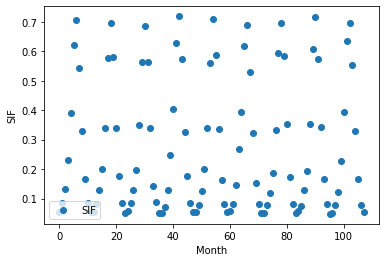

In [9]:
# load sif data 
filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_varR = np.array(nc_sif.variables["RSIF::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_varR.shape # number of rows and columns
sif_varR=sif_varR.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_varR=sif_varR[0:2613*9*12]
ind_sifR=np.isnan(sif_varR)
sif_varR[ind_sifR] = 0
print(sif_varR.shape)

filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var2A = np.array(nc_sif.variables["GOME2A::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var2A.shape # number of rows and columns
sif_var2A=sif_var2A.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var2A=sif_var2A[0:2613*9*12]
sif_var2A[np.isnan(sif_var2A)] = 0
print(sif_var2A.shape)


filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var2B = np.array(nc_sif.variables["GOME2B::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var2B.shape # number of rows and columns
sif_var2B=sif_var2B.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var2B=sif_var2B[0:2613*9*12]
sif_var2B[np.isnan(sif_var2B)] = 0
print(sif_var2B.shape)


filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var_oco2 = np.array(nc_sif.variables["OCO2::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var_oco2.shape # number of rows and columns
sif_var_oco2=sif_var_oco2.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var_oco2=sif_var_oco2[0:2613*9*12]
sif_var_oco2[np.isnan(sif_var_oco2)] = 0

# ISSUE WITH MODIS DATA NEED TO DOUBLE CHECK HOW TIME IS STRUCTURED
# load NIRv data 
filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
nirv_var = np.array(nc_modis.variables["NIRv"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = nirv_var.shape # number of rows and columns\
print(nirv_var.shape)

nirv_var=nirv_var.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
print(nirv_var.shape)

nirv_var=nirv_var[0:2613*9*12]
nirv_var[np.isnan(nirv_var)] = 0
print(nirv_var.shape)

# # load NDVI data 
# filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
# nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
# ndvi_var = np.array(nc_modis.variables["NDVI"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
# num_rows, num_cols = ndvi_var.shape # number of rows and columns\
# print(ndvi_var.shape)

# ndvi_var=ndvi_var.reshape((num_rows*num_cols, 1)) # reshape into one vector by stacking each column (month)
# print(ndvi_var.shape)

# ndvi_var=ndvi_var[0:2613*9*12]
# ndvi_var[np.isnan(ndvi_var)] = 0
# print(ndvi_var.shape)

# #Time MODIS
# filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
# nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
# time_var = np.array(nc_modis.variables["time"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
# print(time_var.shape)


# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(sif_varR, order='F'), (2613,12,9,-1),order='F')
a = np.reshape(np.ravel(nirv_var,order='F'), (2613,12,9,-1),order='F')
# c = np.reshape(np.ravel(ndvi_var,order='F'), (2613,12,9,-1),order='F')

# average by year
b = np.mean(b,axis=0)
a = np.mean(a,axis=0)
# c = np.mean(c,axis=0)

print(b.shape)
# average by month
#b = np.mean(b,axis=1)
b = b.reshape(1,12*9,order='F')

#a = np.mean(a,axis=1)
a = a.reshape(1,12*9,order='F')
# print(X_full_av_mon.shape)
# c = c.reshape(12*9,1,order='F')

# month variable
mon_array = np.arange(0, 12*9, dtype=float)
time_array = np.arange(0, 120, dtype=float)

# plot monthly averages averaged over all North America
# plt.scatter(mon_array,a,label="NIRv")
plt.scatter(mon_array,b,label="SIF")
# plt.scatter(mon_array,c,label="NDVI")
# plt.scatter(time_array,time_var,label="time var")

plt.legend(loc="lower left")
plt.ylabel('SIF')
# plt.ylabel('NDVI')

#plt.ylabel('NIRv')
plt.xlabel('Month')
plt.show()

(282204, 9)
(282204, 1)
(12, 9, 1)


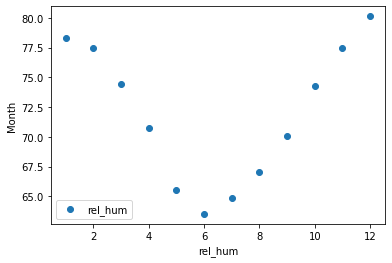

In [10]:
# load in NARR predictors
var_names = ['rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp','precip_16d','precip_30d']

final = []
# loop over variable names
for i in range(0, len(var_names)):
    final.append([]) # append to final
    for number in range(2007, 2016): # loop over years
        #print(number)
        filename_narr = data_dir + "predictors/processed/narr-%d-NA-monthly.nc" % number # file name per year yer variable
        nc_narr = Dataset(filename_narr, 'r')  # open data file using netcdf reader
        #print(i)
        narr_var = np.array(nc_narr.variables["{}".format(var_names[i])]) # create numpy array note shape of narr vars is [space dimension x time dimension] dimension]
        num_rows, num_cols = narr_var.shape # number of rows and columns
        final[i].extend(narr_var.reshape((num_rows*num_cols, 1),order='F')) # reshape into one vector by stacking each column (month)

# print(len(final))
# print(len(final[0]))
# print(len(final[0][0]))
X2 = np.array(final) # create numpy array from list

# print(X.shape)
X2 = np.transpose(np.squeeze(X2)) # transpose and remove singular dimension (squeeze)
print(X2.shape)



# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
num_var=0
b = np.reshape(np.ravel(X2[:,num_var], order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label=var_names[num_var])
plt.legend(loc="lower left")

plt.xlabel(var_names[num_var])
plt.ylabel('Month')
plt.show()


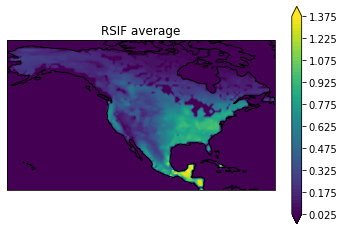

In [11]:
# plotting example

# plot SIF data
SIFR = sif_varR[0:2613*12].reshape(12,2613).mean(axis=0) # reshape and average

# use lat lon from **MODIS** variable ****<<<<<IMPORTANT>>>>>******
lats = nc_modis.variables['lat'][:]
lons = nc_modis.variables['lon'][:]

xi, yi, zi = data2grid(lats,lons,SIFR) # regrid for plotting

# set equal color limits for comparison 
#levels = np.linspace(-1.6, 1.6, 9)

# plot TRUTH

# projection axis
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi, 60,
             transform=ccrs.PlateCarree(),extend='both')
# add coasts
ax.coastlines()

# title
plt.title("RSIF average")
# color bar
plt.colorbar()
plt.show()

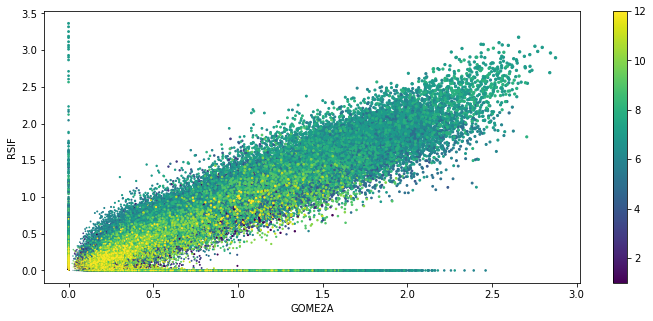

In [12]:
# test plot to visualize different sif products
fig, (ax1) = plt.subplots( 1,1,figsize=(12,5))

a1=ax1.scatter(sif_var2A[:,0], sif_varR[:,0],c=month_vec,s=abs(sif_var2A[:,0])+abs(sif_varR[:,0]))
ax1.set(ylabel='RSIF')
ax1.set(xlabel='GOME2A')
fig.colorbar(a1,ax=ax1)



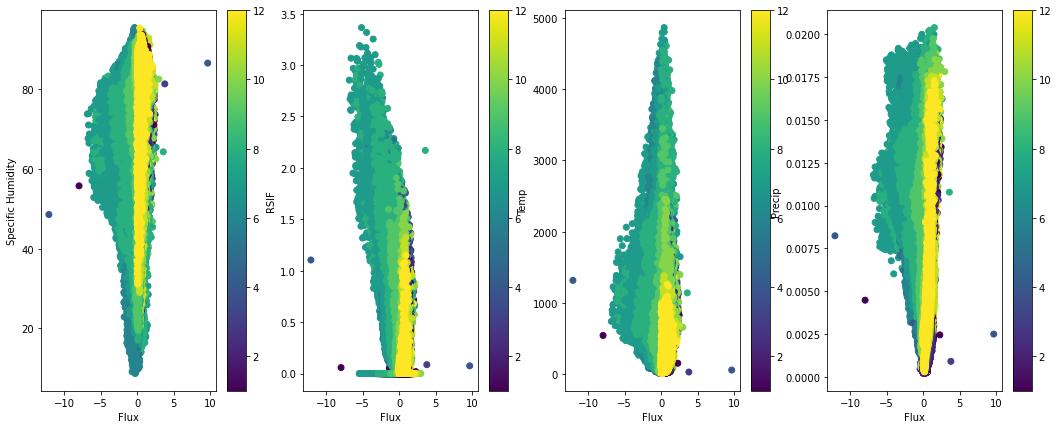

In [13]:
# try plotting variables against flux using month as color
fig, (ax1, ax2, ax3,ax4) = plt.subplots( 1,4,figsize=(18,7))

a1=ax1.scatter(flux_var, X2[:,0],c=month_vec)
ax1.set(ylabel='Specific Humidity')
ax1.set(xlabel='Flux')
fig.colorbar(a1,ax=ax1)

a2=ax2.scatter(flux_var, sif_varR[:,0],c=month_vec)
ax2.set(ylabel='RSIF')
ax2.set(xlabel='Flux')
fig.colorbar(a2,ax=ax2)

a3=ax3.scatter(flux_var, X2[:,5],c=month_vec)
ax3.set(ylabel='Temp')
ax3.set(xlabel='Flux')
fig.colorbar(a3,ax=ax3)


a4=ax4.scatter(flux_var, X2[:,1],c=month_vec)
ax4.set(ylabel='Precip')
ax4.set(xlabel='Flux')
fig.colorbar(a4,ax=ax4)

#fig.tight_layout() 

In [14]:
# Combine all predictors into one large matrix
# NARR, NIRv, Month
# X_full = np.concatenate((X2,sif_var,nirv_var,lon_var_all,lat_var_all,month_vec),axis=1)
var_names = ['rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp','precip_16d','precip_30d']

X_pars = X2[:,4:7] # radiation, vpd, temp, 30d precip
X_narr = np.concatenate((X2,month_vec),axis=1) # All NARR
X_pars_sif = np.concatenate((X_pars,sif_varR),axis=1) # 4 NARR plus sif
X_pars_2_sif = np.concatenate((X2[:,(0,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif
X_pars_3_sif = np.concatenate((X2[:,(0,2,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif
X_pars_4_sif = np.concatenate((X2[:,(2,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif

X_narr_sif_ll = np.concatenate((X2,sif_varR,month_vec,lat_var_all,lon_var_all),axis=1) # ALL NARR plus sif
X_narr_sif = np.concatenate((X2,sif_varR),axis=1) # ALL NARR plus sif

X_pars_4_sif = np.concatenate((X2[:,(2,3,4,5,6)],sif_varR),axis=1) # 'precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month
X_pars_7_sif = np.concatenate((X2[:,(0,1,2,3,4,5,6)],sif_varR),axis=1) # 'rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month




## DEFINE MODEL HERE ###


# 'rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp' (all NARR) and SIF
X_full = X_narr_sif


print(X_full.shape[1])


10


In [15]:
# Create pandas dataframe 
col_names = var_names + ['SIF' ,'Flux']
print(col_names)
df = pd.DataFrame(np.concatenate((X_narr_sif,flux_var),axis=1), columns = col_names)

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

['rel_hum', 'sp_hum', 'precip', 'soil_moisture', 'R_sw', 'vpd', 'temp', 'precip_16d', 'precip_30d', 'SIF', 'Flux']


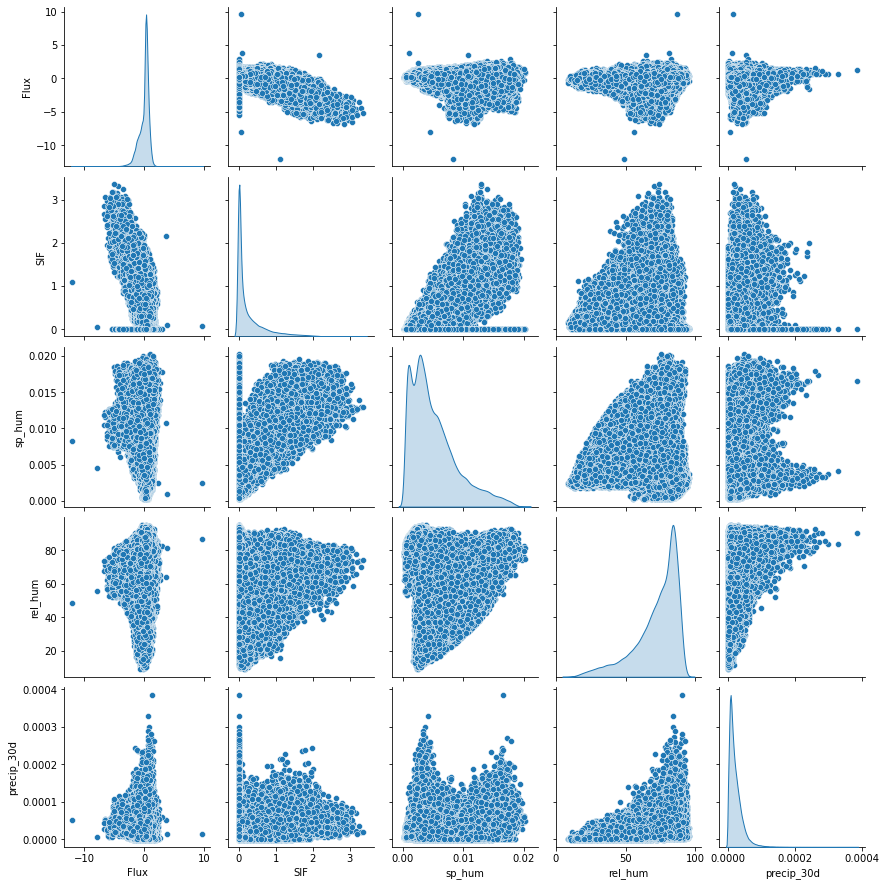

In [16]:
sns.pairplot(train_dataset[['Flux', 'SIF', 'sp_hum','rel_hum','precip_30d']], diag_kind='kde')


In [17]:
# Split into Train and val/test
# Then transform

X_train = X_full[0:2613*8*12,:] # train on first 8 years
y_train = flux_var[0:2613*8*12] # train on first 8 years

X_test = X_full[2613*8*12:,:] # test on last year
y_test = flux_var[2613*8*12:] # test on last year

# transform for NN

# scaler_x = preprocessing.StandardScaler() # scaling zero mean unit variance
#scaler_y = preprocessing.StandardScaler() # scaling zero mean unit variance

# scale predictors between 0-1
scaler_x_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_train.fit(X_train)
#scaler_y_train = preprocessing.MinMaxScaler(feature_range=(0, 1))

# try quantile transformation of flux data see: https://machinelearningmastery.com/quantile-transforms-for-machine-learning/
#scaler_y_train = QuantileTransformer(random_state=0)
#scaler_y_train.fit(y_train)

X_train = scaler_x_train.fit_transform(X_train) # transform training predictors data
#y_train = scaler_y_train.fit_transform(y_train) # transform training flux data

scaler_x_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_test.fit(X_test)

#scaler_y_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
#scaler_y_test = QuantileTransformer(random_state=0)
#scaler_y_test.fit(y_test)


X_test = scaler_x_test.fit_transform(X_test) # transform test predictors data
#y_test = scaler_y_test.fit_transform(y_test) # transform test flux data

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(250848, 10)
(250848, 1)
(31356, 10)
(31356, 1)


In [18]:
# First build a linear model  (see : https://www.tensorflow.org/tutorials/keras/regression)
linear_model = Sequential()
linear_model.add(Dense(1,input_dim=X_full.shape[1], activation='linear'))
optimizer = keras.optimizers.sgd()
linear_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])

In [19]:
# Training
history = linear_model.fit(
    X_train, y_train, 
    epochs=4,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    #validation_split = 0.2
    #Supply validation data = 9th year
    validation_data=(X_test, y_test))


In [20]:
history.history

{'val_loss': [0.46855010222089977,
  0.4626304214288726,
  0.46044469630175333,
  0.4596137270694455],
 'val_mae': [0.46855002641677856,
  0.46263039112091064,
  0.46044448018074036,
  0.4596138596534729],
 'loss': [0.47280588244423144,
  0.44431323980567317,
  0.441053485194401,
  0.4401197707733644],
 'mae': [0.47280568, 0.44431308, 0.44105366, 0.44011945]}

In [21]:
# create plotting function *** note ylim and values from history ****
def plot_loss_2(history,model):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  batch_str= str(history.params['batch_size'])
  lr_str = str(model.optimizer.get_config()['learning_rate'])
  plt.title(('Batch Size = ' +  batch_str + ', Learning rate = ' + lr_str[0:5] ))
  plt.ylim([0, .5])
  plt.xlabel('Epoch')
  plt.ylabel('MAE Error [flux]')
  plt.legend()
  plt.grid(True)


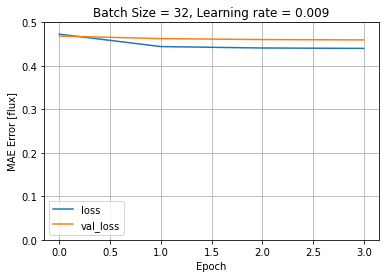

In [22]:
plot_loss_2(history,linear_model)

In [23]:
test_results ={}
test_results['linear_model'] = linear_model.evaluate(
    X_train, y_train, verbose=0)

[[1.        0.6710231]
 [0.6710231 1.       ]]
[-2643.08289804]
[-1387.1003]
-0.08429273179117276
-0.04423753


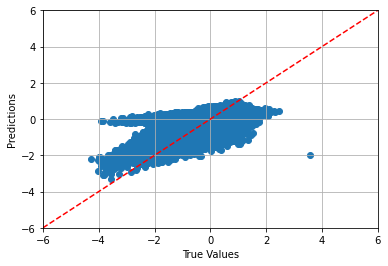

In [24]:
# Scatter plot of estimates and test values
#y_est = scaler_y_test.inverse_transform(linear_model.predict(X_test))
y_est = linear_model.predict(X_test)

a = plt.axes

xy_line = (-6, 6)

# plt.scatter(scaler_y_test.inverse_transform(y_test),y_est)
plt.scatter(y_test,y_est)

plt.plot(xy_line,xy_line ,'--r')

plt.xlabel('True Values')

plt.ylabel('Predictions')

plt.ylim(-6, 6)   # set the xlim to left, right

plt.xlim(-6, 6)  

plt.grid(True)
var1=y_test
# var1=scaler_y_test.inverse_transform(y_test)

var2=y_est

# Basic stats on test predictions

# calculate correlation coefficient
print(np.corrcoef(var1,var2,rowvar=False))
# Calculate sum
print(sum(var1))
print(sum(var2))

# Calculate mean

print(np.mean(var1))
print(np.mean(var2))

In [25]:
# Building a simple NN model
simple_model = Sequential()

# add hidden layer
simple_model.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(BatchNormalization())

simple_model.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(BatchNormalization())

simple_model.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(BatchNormalization())

simple_model.add(Dense(10,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(BatchNormalization())

simple_model.add(Dense(5,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(BatchNormalization())

# add output layer
simple_model.add(Dense(1, activation='linear')) #linear

# set learning rate
optimizer = keras.optimizers.adam()

# pick loss function
simple_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])


In [26]:
print(simple_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               1100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
# Training
history_simple = simple_model.fit(
    X_train, y_train, 
    epochs=15,
    # suppress logging
    verbose=0,
    batch_size = 256,
    shuffle = True,
    # validate using last year of data
    validation_data=(X_test, y_test))
# Calculate validation results on 20% of the training data
    #validation_split = 0.2)

In [ ]:
plot_loss_2(history_simple,simple_model)

In [ ]:
test_results['simple_model'] = simple_model.evaluate(
    X_train, y_train, verbose=0)

In [ ]:
# y_est = scaler_y_test.inverse_transform(simple_model.predict(X_test)) # model estimates for test data (outside of training)
y_est = simple_model.predict(X_test)

a = plt.axes

xy_line = (-6, 6)

# plt.scatter(scaler_y_test.inverse_transform(y_test),y_est)
plt.scatter(y_test,y_est)

plt.plot(xy_line,xy_line ,'--r')

plt.xlabel('True Values')

plt.ylabel('Predictions')

plt.ylim(-6, 6)   # set the xlim to left, right

plt.xlim(-6, 6)  

plt.grid(True)
    
# var1=scaler_y_test.inverse_transform(y_test)
var1=y_test

var2=y_est

# Basic stats on test predictions

# calculate correlation coefficient
print(np.corrcoef(var1,var2,rowvar=False))

# Calculate sum
print(sum(var1)) # sum of truth
print(sum(var2)) # sum of estimates

# Calculate mean

print(np.mean(var1)) # mean of truth
print(np.mean(var2)) # mean of estimates

In [ ]:
pd.DataFrame(test_results).T

In [ ]:
simple_model.evaluate(
    X_test, y_test, verbose=0)

In [ ]:
linear_model.evaluate(
    X_test, y_test, verbose=0)

In [ ]:
# plotting example for test data (not included in training aka 9th year = 2015)
y_est = simple_model.predict(X_test) # model estimates for test data (outside of training)
# y_est = scaler_y_test.inverse_transform(simple_model.predict(X_test)) # model estimates for test data (outside of training)

# plot flux data
flux = y_est.reshape(12,2613).mean(axis=0) # reshape and average

flux_test = flux_var[2613*8*12:]

fluxt = flux_test.reshape(12,2613).mean(axis=0) # reshape and average

# use lat lon from **MODIS** 
lats = nc_modis.variables['lat'][:]

lons = nc_modis.variables['lon'][:]

xi, yi, zi_flux = data2grid(lats,lons,flux) # regrid for plotting "model"

xt, yt, zt_flux = data2grid(lats,lons,fluxt) # regrid for plotting "truth"

xd, yd, zd_flux = data2grid(lats,lons,flux-fluxt) # regrid for plotting "model-truth"

# set equal color limits for comparison 
levels = np.linspace(-1.6, 1.6, 9)

# plot TRUTH

# projection axis
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zt_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')

# add coasts
ax.coastlines()

# title
plt.title("(TEST = 2015) Truth ")

# color bar
plt.colorbar()

plt.show()

In [ ]:
# plot estimates
# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())

levels = np.linspace(-1.6, 1.6, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')

# add coasts
ax.coastlines()

# title
plt.title(" (TEST = 2015) Model estimates ")

plt.colorbar()

plt.show()

In [ ]:
# plot estimates
# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())

levels = np.linspace(-.8, .8, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xd, yd, zd_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),cmap= 'BrBG_r',extend='both')

# add coasts
ax.coastlines()

# title
plt.title("(TEST = 2015) Difference Model minus Truth")

plt.colorbar()

plt.show()

In [ ]:
# plot monthly averages for test year
flux_test = flux_var[2613*8*12:]

print(flux_test.shape)

y_est = simple_model.predict(X_test) # model estimates for test data (outside of training)

print(y_est.shape)

# reshape to average by month
b = np.reshape(np.ravel(flux_test, order='F'), (2613,12,1,-1),order='F')
a = np.reshape(np.ravel(y_est, order='F'), (2613,12,1,-1),order='F') 

# average by year
X_test_mon = np.mean(a,axis=0)
X_tru_mon = np.mean(b,axis=0)

print(X_test_mon.shape)
# average by month
X_test_mon = np.mean(X_test_mon,axis=1)
X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
#plt.scatter(mon_array,X_test_mon[:,0],label="Estimates")

plt.plot(mon_array,X_test_mon[:,0],'-o',label="Estimates: RH+SH+P+SM+R+VPD+T+SIF")

plt.plot(mon_array,X_tru_mon[:,0],'-ok',label="Truth")
#plt.scatter(mon_array,X_tru_mon[:,0],label="Truth")
plt.grid(True)

plt.legend(loc="lower left")

plt.xlabel('Month')

plt.ylabel('Flux')

plt.title('(TEST = 2015) North America average monthly')

fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.show()


In [ ]:
# Plot grid cell annual average scatter truth vs est

y_est = simple_model.predict(X_test) # model estimates for test data (outside of training)

flux = y_est.reshape(12,2613).mean(axis=0) # reshape and average model estimate

flux_test_tru = flux_var[2613*8*12:] # test target data

flux_test_tru = flux_test_tru.reshape(12,2613).mean(axis=0) # reshape and average truth

plt.scatter(flux_test_tru,flux)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.title('(TEST = 2015) Grid cell annual average for North America')
lim_val= 1.5
plt.xlim(-lim_val,lim_val)
plt.ylim(-lim_val, lim_val)
xy_line = (-lim_val ,lim_val)
plt.grid
plt.plot(xy_line,xy_line ,'--r')

In [ ]:
# Plot monthly average time series for model adn target during training period

# y_est_train_m = scaler_y_test.inverse_transform(simple_model.predict(X_train))
y_est_train_m = simple_model.predict(X_train)

y_train_orig = flux_var[0:2613*8*12] # train on first 8 years

# plot monthly timeseries
print(flux_test.shape)

print(y_est.shape)

# reshape to average by month
mod_m = np.reshape(np.ravel(y_est_train_m, order='F'), (2613,12,8,-1),order='F')
tru = np.reshape(np.ravel(y_train_orig, order='F'), (2613,12,8,-1),order='F')

# average by year
X_test_mod_m = np.reshape(np.mean(mod_m,axis=0),(1,-1),order='F')
X_tru_mon = np.reshape(np.mean(tru,axis=0),(1,-1),order='F')

# annual average (climatological) 
X_test_mod_ann= np.mean(np.mean(mod_m,axis=1),axis=1)
X_tru_ann = np.mean(np.mean(tru,axis=1),axis=1)

print(X_test_mon.shape)

# month variable
mon_array = np.arange(1,97 ,dtype=float)

# plot monthly averages averaged over all North America
#precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month

plt.plot(mon_array,X_test_mod_m[0,:],'-o',label="Estimates: RH+SH+P+SM+R+VPD+T+SIF")

plt.plot(mon_array,X_tru_mon[0,:],'-ok',label="Truth")

plt.legend(loc="lower left")

plt.title("(TRAINING = 2007-2014) Average North America monthly time series ")

plt.xlabel('Month')
plt.ylabel('Flux')
fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.grid(True)
plt.show()

# Plot grid cell annual average scatter truth vs est

plt.scatter(X_tru_ann,X_test_mod_ann)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('(TRAINING = 2007-2014) Grid cell annual average for North America (spatial)')
lim_val= 1.5
plt.xlim(-lim_val,lim_val)
plt.ylim(-lim_val, lim_val)
xy_line = (-lim_val ,lim_val)
plt.grid(True)
plt.plot(xy_line,xy_line ,'--r')

fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.grid(True)


In [ ]:
# Plot monthly NA average scatter truth vs est
plt.scatter(X_tru_mon[0,:],X_test_mod_m[0,:],c=mon_array)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('(TRAINING = 2007-2014) Monthly Averages for North America')
lim_val= 1.5
plt.xlim(-lim_val,lim_val)
plt.ylim(-lim_val, lim_val)
xy_line = (-lim_val ,lim_val)
plt.grid(True)

plt.plot(xy_line,xy_line ,'--r')

fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.grid(True)
# calculate correlation coefficient (in time for monthly North America averages)
C_mon=np.corrcoef(X_tru_mon[0,:],X_test_mod_m[0,:],rowvar=False)
print((C_mon[0,1]))

# calculate correlation coefficient (in space for long term annual average)
C_space=np.corrcoef(X_test_mod_ann,X_tru_ann,rowvar=False)
print((C_space[0,1]))


In [ ]:
# Plot monthly anomalies

y_est_train_m = simple_model.predict(X_train)
# y_est_train_m = scaler_y_test.inverse_transform(simple_model.predict(X_train))
y_train_orig = flux_var[0:2613*8*12] # train on first 8 years

# plot monthly timeseries
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
mod_m = np.reshape(np.ravel(y_est_train_m, order='F'), (2613,12,8,-1),order='F')
tru = np.reshape(np.ravel(y_train_orig, order='F'), (2613,12,8,-1),order='F')
print(mod_m.shape)

# average monthly rearrange to timeseries
X_test_mod_m = np.reshape(np.mean(mod_m,axis=0),(1,-1),order='F')
X_tru_mon = np.reshape(np.mean(tru,axis=0),(1,-1),order='F')
print(X_test_mod_m.shape)


# annual average (climatological) 
X_test_mod_ann= np.mean(np.mean(mod_m,axis=1),axis=1)
X_tru_ann = np.mean(np.mean(tru,axis=1),axis=1)

print(X_test_mod_ann.shape)

mon_array = np.arange(1,97 ,dtype=float)
# plot monthly anomalies averaged over all North America
#rel_hum, sp_hum,precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month

plt.plot(mon_array,X_test_mod_m[0,:]-X_tru_mon[0,:],'--o',label="Model minus Truth: RH+SH+P+SM+R+VPD+T+SIF")
plt.plot((0,97),(0,0),'--r')
plt.legend(loc="lower left")

plt.title("(Model minus Truth) Monthly North American average time series ")

plt.xlabel('Month')
plt.ylabel('Flux')
plt.xlim(0, 97)
plt.ylim(-.4, .4)
plt.xticks(np.arange(1, 97, step=12))
fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.grid()
plt.show()